[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/inseq-team/inseq/blob/main/examples/inseq_tutorial.ipynb)

In [1]:
%%capture
# Run in Colab to install local packages
%pip install bitsandbytes accelerate transformers inseq

This tutorial showcases how to use the [inseq](https://github.com/inseq-team/inseq) library for various interpretability analyses, with a focus on advanced use cases such as aggregation and contrastive attribution. The tutorial was adapted from the [LCL'23 tutorial on Interpretability for NLP](https://github.com/gsarti/lcl23-xnlm-lab) with the goal of updating it whenever new functionalities or breaking changes are introduced.

⚠️ **IMPORTANT** ⚠️ : `inseq` is a very new library and under active development. Current results were obtained using the latest inseq release. If you find any issue, or you are not able to reproduce the results shown here, we'd love if you could open an issue on [the inseq Github repository](https://github.com/inseq-team/inseq) so that we could update the tutorial accordingly! 🙂

# Introduction: Feature Attribution for NLP

*See [Madsen et al. 2022](https://dl.acm.org/doi/10.1145/3546577) for a survey on feature attribution methods for NLP applications.*

**Feature attribution methods** leverage the internal information (e.g. gradients, attention) or predictions of a model to quantify the relationship between its inputs and its predictions.

Attribution methods produce **importance scores** (or *saliency scores*) for every element of the input, reflecting the importance of every input element in driving the model prediction. These scores are often presented using <span style="background:#A85E9E">highlights</span> (or *attribution maps*) to facilitate comprehension, although recent research showed the risks of textual highlights misinterpretation caused by human cognitive biases ([Jacovi et al. 2022](https://dl.acm.org/doi/abs/10.1145/3531146.3533127), [Jacovi et al. 2023](https://arxiv.org/abs/2305.02679))

<img alt="Example of attribution map for sentiment analysis" src="https://dl.acm.org/cms/asset/b4fe400e-9eb7-4f10-ab49-ac6a31a8a5cf/csur-2021-0674-f03.jpg" height="150"/>

*Hypothetical example of attribution map for sentiment analysis from [Madsen et al. 2022](https://dl.acm.org/doi/10.1145/3546577). c represents the explained (predicted) class, while y is the correct label for the example.*

We can categorize feature attribution approaches in three major families:

- **Gradient-based methods** such as [Integrated gradients]() use gradients as a natural source of information to motivate model predictions. Gradients for model parameters computed in relation to a loss function are commonly used during training to update model parameters, since they represent *the magnitude of change needed for a parameter such that the prediction matches the target label*. In the case of feature attribution, gradients computed with respect to a model prediction logit or probability are instead taken as *how much the parameter is contributing towards the prediction*.

<img alt="How gradient attribution is computed" src="../docs/source/images/lm_gradient_attribution.png" height=400/>

*Overview of feature attribution using gradient information. Adapted from Jay Alammar blog post "[Interfaces for Explaining Transformer Language Models](https://jalammar.github.io/explaining-transformers/)"*

- **Perturbation-based methods** such as [Occlusion](https://captum.ai/api/occlusion.html) estimate importance of inputs by introducing noise in the prediction process, usually by masking or removing either input features or network components, and verifying the downstream effect on model predictions. Intuitively, these can also be used to determine the importance of layers in the neural network.

<img alt="How occlusion attribution is computed" src="../docs/source/images/lm_perturbation_attribution.png" height=400/>

- **Internals-based methods** use quantities computed naturally by the network during their predictions to motivate its internal computations. For Transformers-based model, [attention weights](https://aclanthology.org/D19-1002/) are commonly used, by themselves or multiplied with other quantities, as indications of feature importance.

<img alt="Aligning words across source and target sentences in translation with attention" src="https://jalammar.github.io/images/attention_sentence.png" height=400/>

*Example of attention weights aligning source and target words in a translation task. From Bahdanau et al. 2015 "[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)"*


<details>
    <summary><b>Additional details about feature attribution methods</b></summary>
    <ol>
        <li> We distinguish gradient and internals methods since gradient methods require a <i>prediction target</i> (e.g. the predicted class label, the next generated word) to compute importance scores, while internals-based one generally do not rely on the predicted output to determine importance.</li>
        </br>
        <li> Feature importance is generally computed for input tokens, but most methods can also be used to compute importance of intermediate representations (or <i>activations</i>) computed by the model (e.g. stopping at an intermediate layer when backpropagating gradients).</li>
        </br>
        <li> Methods using layer-specific quantities like attention weights usually aggregate those across layers to obtain a proxy importance for input features, either averaging naively or with more reasonable methods such as <a href="https://aclanthology.org/2020.acl-main.385/">rollout and flow</a>.</li>
        </br>
        <li>The granularity of importance scores depend on the attribution method that is being used. For example, the attention mechanism operates at a token level, so attention weights used as importance scores will be one per token in the input sequence. Gradients, on the contrary, are computed for all the dimensions of each token embedding, so an aggregation strategy should be used to obtain a single score per token.</li>
    </ol>
</details>

## Attributing Generative Language Models with Inseq

*Adapted in part from the [Inseq documentation](https://inseq.readthedocs.io/)*

[Inseq](https://github.com/inseq-team/inseq) ([Sarti et al., 2023](https://arxiv.org/abs/2302.13942)) is a toolkit based on the [🤗 Transformers](https//github.com/huggingface/transformers) and [Captum](https://captum.ai/docs/introduction) libraries for intepreting language generation models using feature attribution methods. Inseq allows you to analyze the behavior of a language generation model by computing the importance of each input token for each token in the generated output using the various categories of attribution methods like those described in the previous section (use `inseq.list_feature_attribution_methods()` to list all available methods). You can refer to the [Inseq paper](https://arxiv.org/abs/2302.13942) for an overview of the tool and some usage examples.

Inseq supports all [`AutoModelForSeq2SeqLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSeq2SeqLM) (among others, [T5](https://huggingface.co/docs/transformers/model_doc/t5), [Bart](https://huggingface.co/docs/transformers/model_doc/bart) and all >1000 [MarianNMT](https://huggingface.co/docs/transformers/model_doc/marian) MT models) and [AutoModelForCausalLM](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) (among others, [GPT-2](https://huggingface.co/docs/transformers/model_doc/gpt2), [Bloom](https://huggingface.co/docs/transformers/model_doc/bloom) and [LLaMa](https://huggingface.co/docs/transformers/model_doc/llama)), including advanced tools for custom attribution targets and post-processing of attribution matrices.

The following code is a "Hello world" equivalent in Inseq: in three lines of code, an English-to-Italian machine translation model is loaded alongside an attribution method, attribution is performed, and results are visualized:

In [1]:
import inseq

# Load the model Helsinki-NLP/opus-mt-en-fr (6-layer encoder-decoder transformer) from the
# Huggingface Hub and hook it with the Input X Gradient feature attribution method
model = inseq.load_model("Helsinki-NLP/opus-mt-en-it", "input_x_gradient")

# Generate the translation for input_texts and attribute inputs at every steps of the generation
# attribute_target=True is used to include the target prefix in the attributed inputs (2nd matrix)
# step scores are computed at every step and returned alongsides attribution scores
out = model.attribute(
    input_texts="Hello everyone, hope you're enjoying the tutorial!",
    attribute_target=True,
    step_scores=["probability"],
)
# Visualize the attributions and step scores
out.show()

/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/generation/utils.py:1349: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformer

,▁Ci,a,o,▁a,▁tutti,",",▁spero,▁che,▁vi,▁stia,te,▁gode,ndo,▁il,▁tu,tori,al,!,</s>
▁H,0.115,0.096,0.061,0.076,0.051,0.086,0.046,0.063,0.063,0.065,0.021,0.028,0.034,0.031,0.046,0.011,0.008,0.071,0.065
ello,0.151,0.137,0.088,0.112,0.081,0.101,0.05,0.077,0.082,0.073,0.024,0.033,0.042,0.039,0.055,0.013,0.008,0.085,0.077
▁everyone,0.111,0.093,0.066,0.147,0.15,0.065,0.054,0.058,0.064,0.043,0.018,0.022,0.025,0.029,0.039,0.01,0.009,0.059,0.057
",",0.062,0.047,0.031,0.05,0.044,0.05,0.05,0.042,0.042,0.03,0.012,0.015,0.017,0.02,0.027,0.013,0.006,0.04,0.037
▁hope,0.082,0.06,0.034,0.056,0.048,0.055,0.227,0.079,0.057,0.05,0.036,0.044,0.029,0.026,0.03,0.012,0.008,0.046,0.043
▁you,0.036,0.029,0.014,0.031,0.023,0.033,0.042,0.033,0.033,0.031,0.019,0.018,0.012,0.017,0.019,0.007,0.005,0.03,0.027
',0.045,0.036,0.014,0.036,0.024,0.048,0.035,0.039,0.036,0.046,0.024,0.022,0.016,0.022,0.027,0.01,0.006,0.039,0.034
re,0.04,0.03,0.011,0.035,0.021,0.043,0.03,0.034,0.035,0.047,0.021,0.027,0.017,0.019,0.023,0.007,0.008,0.036,0.032
▁enjoying,0.091,0.066,0.031,0.066,0.052,0.093,0.096,0.101,0.159,0.17,0.181,0.305,0.089,0.049,0.052,0.026,0.021,0.088,0.078
▁the,0.032,0.023,0.011,0.022,0.015,0.029,0.025,0.028,0.042,0.038,0.037,0.062,0.023,0.043,0.038,0.042,0.029,0.027,0.025


The `attribute` method supports a wide range of customizations. Among others:

- Specifying one string in `generated_texts` for every sentence in `input_texts` allows attributing custom generation outputs (i.e. *constrained decoding*). This can be useful to answer questions such as *"How would the following output be justified in light of the inputs by the model?"*, or to analyze minimal pairs.

- `attribute_target`: Specific to encoder-decoder models, can be used to specify that target-side prefix should also be attributed besides the original source-to-target attribution. This would populate the `target_attribution` filed in the output, which would otherwise be left empty. In the decoder-only case, the parameter is not used since only the prefix is attributed by default, and there is no source sequence.

- `step_scores` allows for computing custom scores at every generation step, with some such as token `probability` and output distribution `entropy` being defined by default in Inseq.

- `attributed_fn` allows defining a custom output function for the model, enabling advanced use cases such as [contrastive explanations](https://arxiv.org/abs/2202.10419).

### The FeatureAttributionOutput class

The output returned by the `model.attribute` function contains attribution tensors, plus rich information regarding the attribution settings:

In [2]:
out

FeatureAttributionOutput({
    sequence_attributions: list with 1 elements of type GranularFeatureAttributionSequenceOutput:[
        GranularFeatureAttributionSequenceOutput({
            source: list with 14 elements of type TokenWithId:[
                '▁H', 'ello', '▁everyone', ',', '▁hope', '▁you', ''', 're', '▁enjoying', '▁the', '▁tutor', 'ial', '!', '</s>'
            ],
            target: list with 19 elements of type TokenWithId:[
                '▁Ci', 'a', 'o', '▁a', '▁tutti', ',', '▁spero', '▁che', '▁vi', '▁stia', 'te', '▁gode', 'ndo', '▁il', '▁tu', 'tori', 'al', '!', '</s>'
            ],
            source_attributions: torch.float32 tensor of shape [14, 19, 512] on cpu,
            target_attributions: torch.float32 tensor of shape [19, 19, 512] on cpu,
            step_scores: {
                probability: torch.float32 tensor of shape [19] on cpu: [
                     0.47,  0.91,  0.91,  0.87,  0.91,  0.74,  0.51,  0.49,  0.67,  0.71,  0.65,  0.74,  0.95,  0.80, 

Here is an explanation of the various fields:

- `sequence_attributions` is a list containing a `FeatureAttributionSequenceOutput` per attributed sequence (in this case just one). These object contain the main information derived from the attribution process, including `source_attributions` and `target_attributions`, the tokenized `source` and `target` sequences and all `step_scores` that were computed for the generation.

- `step_scores` are usually empty, but can be filled with `FeatureAttributionStepOutput` (per-step attributions across all examples instead of per-example attributions across all-steps, like `sequence_attributions`) by passing the parameter `output_step_attributions=True` to `model.attribute()`.

- `info` is a dictionary containing a lot of information about the overall process, including attributed model and attribution methods, execution time and all parameters that were used for generation and attribution.

Both the `FeatureAttributionSequenceOutput` class and the visualization can be easily serialized as follows, to be reloaded later on for analysis:

In [8]:
out.save("marian_en_it_attribution.json")

# Reload the saved output
reloaded_out = inseq.FeatureAttributionOutput.load("marian_en_it_attribution.json")

html = reloaded_out.show(display=False, return_html=True)

with open("marian_en_it_attribution.html", "w") as f:
    f.write(html)

### Post-processing Attributions with Aggregators

You might have noticed that the shape of the `source_attributions` tensor in `out` is [12, 17, 512] (source length x target length x hidden size) because we are using a gradient-based attribution method returning one importance score per hidden dimension, but when calling `out.show()` the output is a matrix of shape [12, 17].

This is because every attribution method is automatically assigned an appropriate default `Aggregator`, which is called implicitly on `out.show()` to ensure that attributions can be visualized out-of-the-box. In this case the default aggregation involves taking the L2 norm of the hidden size (i.e. the *magnitude* of the importance score vector, strictly positive) and then normalize scores to ensure that all importance scores for every generated token (columns) across `source_attributions` and `target_attributions` sum to one. The normalization step is included since it allows us to express the *relative importance* of input features when generating the target token at every step.

We can see now another example using the `attention` attribution method, returning simply attention weights for the model (note that we do not need to reload the model, but it is sufficient to pass a new `method` identifier to `model.attribute`):

In [3]:
out = model.attribute(
    input_texts="Hello everyone, hope you're enjoying the tutorial!", attribute_target=True, method="attention"
)
# out[0] is a shortcut for out.sequence_attributions[0]
out[0].source_attributions.shape

Attributing with attention...: 100%|██████████| 20/20 [00:00<00:00, 98.32it/s] 


torch.Size([14, 19, 6, 8])

The attribution matrix produced by `attention` has dimensions (source length, sequence length, # layers, # attention heads), so `out[0].source_attributions[:, 2, 3, 4]` are attention weights associated to source tokens by the 4th attention head of the 3rd layer, produced when generating the 2nd target token. We can see the aggregation strategy employed by default as follows:

In [4]:
out[0]._aggregator
out.show()

,▁Ci,a,o,▁a,▁tutti,",",▁spero,▁che,▁vi,▁stia,te,▁gode,ndo,▁il,▁tu,tori,al,!,</s>
▁H,0.106,0.144,0.063,0.056,0.014,0.012,0.014,0.006,0.005,0.002,0.003,0.003,0.002,0.003,0.003,0.003,0.001,0.003,0.006
ello,0.086,0.16,0.091,0.082,0.018,0.016,0.013,0.006,0.006,0.003,0.003,0.003,0.002,0.003,0.003,0.003,0.002,0.003,0.005
▁everyone,0.065,0.052,0.047,0.201,0.188,0.155,0.029,0.017,0.012,0.005,0.005,0.004,0.003,0.004,0.005,0.007,0.003,0.004,0.004
",",0.091,0.023,0.013,0.027,0.021,0.092,0.153,0.021,0.015,0.005,0.004,0.003,0.004,0.004,0.006,0.002,0.001,0.002,0.015
▁hope,0.057,0.026,0.015,0.02,0.017,0.06,0.209,0.144,0.086,0.019,0.013,0.01,0.008,0.008,0.005,0.005,0.003,0.005,0.004
▁you,0.013,0.008,0.003,0.004,0.008,0.01,0.017,0.079,0.095,0.129,0.022,0.036,0.007,0.008,0.008,0.004,0.002,0.004,0.003
',0.006,0.003,0.001,0.002,0.004,0.004,0.009,0.023,0.025,0.021,0.043,0.022,0.004,0.004,0.003,0.001,0.001,0.002,0.002
re,0.008,0.004,0.002,0.004,0.005,0.006,0.011,0.032,0.035,0.032,0.063,0.034,0.006,0.007,0.004,0.002,0.001,0.003,0.003
▁enjoying,0.017,0.011,0.005,0.006,0.018,0.014,0.025,0.081,0.11,0.223,0.142,0.189,0.135,0.098,0.021,0.01,0.006,0.011,0.007
▁the,0.031,0.004,0.004,0.005,0.007,0.008,0.011,0.025,0.035,0.031,0.032,0.023,0.023,0.09,0.138,0.009,0.006,0.023,0.013


This means that the `mean` of weights across all heads and layers is computed before showing the attributions. Let's now try to customize the aggregation strategy to return a more specific view of the outputs using `out.aggregate` 

*Note: the list of `Aggregator` classes is available using `inseq.list_aggregators()`. The `mean` is an aggregation function (the list of aggregation functions is available using `inseq.list_aggregation_functions()`) which can be associated to an aggregator, but if not specified is used to aggregate the list dimension of the attribution by default (aggregator `scores`)*

In [5]:
print("Aggregators:", inseq.list_aggregators())
print("Aggregation functions:", inseq.list_aggregation_functions())

Aggregators: ['spans', 'pair', 'subwords', 'scores']
Aggregation functions: ['vnorm', 'absmax', 'prod', 'sum', 'max', 'min', 'mean']


In [6]:
# Gets the mean weights of the first three attention heads only, no normalization
# do_post_aggregation_checks=False is needed since the output has >2 dimensions and
# could not be visualized
aggregated_heads_seq_attr_out = out[0].aggregate(
    "mean", select_idx=(0, 3), normalize=False, do_post_aggregation_checks=False
)

# (source_len, target_len, num_layers)
print("aggregated_heads_seq_attr_out:", aggregated_heads_seq_attr_out.source_attributions.shape)

# Shortcut for aggregate("scores", aggregate_fn="max", ...)
# Selects attention weights for the last layer of the model, no normalization
aggregated_layer_seq_attr_out = aggregated_heads_seq_attr_out.aggregate("scores", select_idx=-1, normalize=False)

# (source_len, target_len)
print("aggregated_layer_seq_attr_out:", aggregated_layer_seq_attr_out.source_attributions.shape)

# do_aggregation=False to prevent automatic default aggregation since we did a custom one manually
aggregated_layer_seq_attr_out.show(do_aggregation=False)

aggregated_heads_seq_attr_out: torch.Size([14, 19, 6])
aggregated_layer_seq_attr_out: torch.Size([14, 19])


,▁Ci,a,o,▁a,▁tutti,",",▁spero,▁che,▁vi,▁stia,te,▁gode,ndo,▁il,▁tu,tori,al,!,</s>
▁H,0.13,0.013,0.003,0.027,0.002,0.007,0.005,0.003,0.001,0.003,0.007,0.005,0.0,0.001,0.001,0.002,0.001,0.001,0.009
ello,0.093,0.024,0.004,0.024,0.002,0.006,0.003,0.002,0.001,0.002,0.004,0.004,0.0,0.0,0.001,0.003,0.001,0.001,0.009
▁everyone,0.076,0.074,0.024,0.154,0.39,0.09,0.019,0.119,0.076,0.004,0.019,0.009,0.003,0.011,0.012,0.017,0.011,0.005,0.007
",",0.021,0.079,0.065,0.025,0.009,0.023,0.013,0.011,0.002,0.001,0.001,0.001,0.03,0.001,0.0,0.001,0.002,0.001,0.001
▁hope,0.26,0.014,0.01,0.087,0.006,0.374,0.502,0.026,0.017,0.009,0.012,0.015,0.001,0.001,0.001,0.003,0.003,0.003,0.005
▁you,0.009,0.003,0.001,0.002,0.005,0.01,0.032,0.047,0.071,0.012,0.01,0.006,0.013,0.012,0.006,0.002,0.004,0.008,0.003
',0.007,0.005,0.001,0.007,0.0,0.014,0.023,0.042,0.036,0.048,0.021,0.033,0.001,0.006,0.006,0.001,0.002,0.005,0.001
re,0.01,0.005,0.001,0.01,0.0,0.019,0.03,0.057,0.055,0.07,0.032,0.055,0.001,0.009,0.01,0.002,0.003,0.007,0.002
▁enjoying,0.007,0.007,0.004,0.004,0.001,0.013,0.018,0.214,0.247,0.318,0.45,0.448,0.002,0.016,0.006,0.012,0.005,0.006,0.005
▁the,0.005,0.003,0.005,0.003,0.001,0.005,0.004,0.037,0.04,0.01,0.02,0.044,0.021,0.12,0.046,0.011,0.009,0.007,0.003


We can now use a `SubwordAggregator` to aggregate these scores at the word level to facilitate interpretation:

In [7]:
aggregated_layer_seq_attr_out.aggregate("subwords").show(do_aggregation=False)

,▁Ciao,▁a,"▁tutti,",▁spero,▁che,▁vi,▁stiate,▁godendo,▁il,▁tutorial!,</s>
▁Hello,0.13,0.027,0.007,0.005,0.003,0.001,0.007,0.005,0.001,0.003,0.009
"▁everyone,",0.079,0.154,0.39,0.019,0.119,0.076,0.019,0.03,0.011,0.017,0.007
▁hope,0.26,0.087,0.374,0.502,0.026,0.017,0.012,0.015,0.001,0.003,0.005
▁you're,0.01,0.01,0.019,0.032,0.057,0.071,0.07,0.055,0.012,0.01,0.003
▁enjoying,0.007,0.004,0.013,0.018,0.214,0.247,0.45,0.448,0.016,0.012,0.005
▁the,0.005,0.003,0.005,0.004,0.037,0.04,0.02,0.044,0.12,0.046,0.003
▁tutorial!,0.15,0.041,0.028,0.019,0.039,0.02,0.014,0.227,0.035,0.641,0.014
</s>,0.721,0.602,0.573,0.325,0.377,0.411,0.509,0.695,0.754,0.882,0.925
,▁Ciao,▁a,"▁tutti,",▁spero,▁che,▁vi,▁stiate,▁godendo,▁il,▁tutorial!,</s>
▁Ciao,,0.463,0.03,0.015,0.011,0.006,0.003,0.005,0.0,0.003,0.004


### Applied Example: Does my QA Model Behave in a Plausible Way?

In this example, we use an [IT5 model](https://github.com/gsarti/it5) ([Sarti et al., 2022](https://arxiv.org/abs/2203.03759)) fine-tuned on the [SQUAD-IT](https://github.com/crux82/squad-it) QA dataset ([Croce et al., 2018](https://link.springer.com/chapter/10.1007/978-3-030-03840-3_29)) to do question answering in Italian. Using Inseq, we visualize whether the model prediction use input information that is plausible according to human intuition.

In [1]:
import inseq

question = (
    "Nel 2023, le Lectures on Computational Linguistics (LCL) dell'Associazione Italiana di "
    "Linguistica Computazionale (AILC) hanno raccolto una partecipazione senza precedenti. Più "
    "di 200 studenti da tutta Europa hanno visitato la magnifica città di Pisa per spendere 3 produttive "
    "giornate all'insegna del trattamento automatico del linguaggio. Iniziative come le LCL sono di importanza "
    "fondamentale per unire e dirigere gli sforzi della comunità italiana di ricercatori in linguistica computazionale. "
    "Domanda: Quanti studenti hanno partecipato alle LCL nel 2023?"
)

qa_model = inseq.load_model("it5/it5-base-question-answering", "input_x_gradient")
out = qa_model.attribute(question, attribute_target=True, step_scores=["probability"])

# Aggregate only source tokens, leave target tokens as they are
out.aggregate("subwords", aggregate_target=False).show()

/home/gsarti/projects/lcl23-xnlm-lab/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gsarti/projects/lcl23-xnlm-lab/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1349: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with input_x_gradient...: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


,▁,2,0,0,</s>
▁nel,0.014,0.012,0.017,0.021,0.022
"▁2023,",0.017,0.018,0.029,0.056,0.043
▁le,0.004,0.006,0.006,0.004,0.006
▁lectures,0.012,0.016,0.014,0.014,0.025
▁on,0.004,0.005,0.004,0.005,0.004
▁computational,0.011,0.013,0.013,0.01,0.01
▁linguistics,0.006,0.008,0.007,0.006,0.007
▁(lcl),0.005,0.007,0.006,0.006,0.006
▁dell'associazione,0.012,0.013,0.009,0.009,0.008
▁italiana,0.008,0.009,0.008,0.008,0.007


Some comments on the results:

- The answer produced by the model is correct and probability is extremely high, so we can assume that the model is confident in its correct prediction and that it is reasonable to evaluate how it uses inputs to produce the answer.

- The magnitude of importance scores is quite low. This points to the known issue of gradient-based methods of producing explanations that are not **sparse** (i.e. only some tokens are highlighted). This makes analysis less intuitive, so methods inducing sparse explanations should be preferred, *especially given long inputs*.

- The model seems to rely on reasonable cues (`200 studenti` in the context, `quanti studenti` in the question) while generating an answer. However, some attended inputs might be surprising (`2023`, `senza precedenti`). Previous research showed that these might be good starting points to craft **adversarial attacks** to test the robustness of model predictions.

## Using PairAggregator for Minimal Pair Comparison

The `PairAggregator` class allows to compare the attributions of two sequences, and is useful to compare the attributions of two similar sentences, or to compare the attributions of two different models. In this example, we'll see how to use it alongside **constrained decoding** of target sequences (i.e. forcing the generation of a target sequence of our choice) in Inseq to analyze how attributions differ across different cases.

⚠️ **Attention:** Analyzing model behavior when doing constrained decoding doesn't always make sense, and ideally we would want to work on natural model generations to remain faithful to plausible model behavior (see [Vamvas and Sennrich (2021)](https://aclanthology.org/2021.blackboxnlp-1.5/) for a discussion on this topic). However, constrained decoding is a useful tool to analyze minimal examples that differ from natural model outputs.

⚠️ **Attention x 2:** Two attribution maps need to have exactly the same number of rows and columns to be compared using `PairAggregator`. You might have to aggregate subwords beforehand like shown above to make sure that this is the case. 

In [8]:
import inseq

model = inseq.load_model("gpt2", "integrated_gradients")

# Uses Huggingface generate method + automatically decodes outputs
natural_generation = model.generate("The manager went home because", max_new_tokens=4)[0]

print("Natural output:", natural_generation)

# Why "he" rather than "she"?
out = model.attribute(
    input_texts=["The manager went home because", "The manager went home because"],
    # generated_texts is used to force the attribution of the specified texts
    generated_texts=["The manager went home because he was sick.", "The manager went home because she was sick."],
    step_scores=["probability"],
)

out.show()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Natural output: The manager went home because he was sick.


Attributing with integrated_gradients...: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


,Ġhe,Ġwas,Ġsick,.
The,0.201,0.224,0.147,0.157
Ġmanager,0.385,0.149,0.187,0.144
Ġwent,0.124,0.145,0.113,0.131
Ġhome,0.165,0.12,0.262,0.143
Ġbecause,0.125,0.168,0.123,0.075
Ġhe,,0.194,0.071,0.044
Ġwas,,,0.097,0.062
Ġsick,,,,0.244
.,,,,
probability,0.43,0.251,0.067,0.282


,Ġshe,Ġwas,Ġsick,.
The,0.27,0.241,0.152,0.158
Ġmanager,0.472,0.148,0.18,0.143
Ġwent,0.077,0.135,0.122,0.153
Ġhome,0.102,0.095,0.276,0.16
Ġbecause,0.079,0.154,0.109,0.076
Ġshe,,0.227,0.072,0.068
Ġwas,,,0.089,0.057
Ġsick,,,,0.186
.,,,,
probability,0.08,0.281,0.071,0.29


In [9]:
# Note: this takes the per-hidden dimension diff between the two options and then performs L2 aggregation at token level + normalization
out[0].aggregate("pair", paired_attr=out[1], do_post_aggregation_checks=False).show()

,Ġhe → Ġshe,Ġwas,Ġsick,.
The,0.248,0.144,0.131,0.09
Ġmanager,0.462,0.213,0.165,0.175
Ġwent,0.095,0.053,0.127,0.095
Ġhome,0.114,0.077,0.229,0.094
Ġbecause,0.081,0.173,0.094,0.077
Ġhe → Ġshe,,0.34,0.186,0.175
Ġwas,,,0.068,0.057
Ġsick,,,,0.237
.,,,,
probability,-0.35,0.03,0.004,0.008


From the example, we can see that the model is 35% more likely to generate the masculine pronoun `he` when referring to the noun `the manager` compared to its feminine counterpart `she`, while probabilities of all subsequent tokens are much less affected. The pattern of the previous attributions is mostly preserved, with `manager` influencing the generation of the pronoun and `home` influencing the choice of word `sick`.

### Understanding Inseq utilities with `explain`

Like Hugging Face, Inseq uses strings to identify many of its components (attribution methods, aggregators, aggregation functions, ...). 

Besides the `list_XXX` functions mentioned above that can be used to show available values, `inseq` also provides an `explain` utility to visualize the docstring of the class associated to the string identifier: 

In [8]:
import inseq

inseq.explain("integrated_gradients")

Integrated Gradients attribution method.

    Reference implementation:
    `https://captum.ai/api/integrated_gradients.html <https://captum.ai/api/integrated_gradients.html>`__.
    


In [10]:
inseq.explain("pair")

Aggregates two FeatureAttributionSequenceOutput object into a single one containing the diff.

    Args:
        attr (:class:`~inseq.data.FeatureAttributionSequenceOutput`): The starting attribution object.
        paired_attr (:class:`~inseq.data.FeatureAttributionSequenceOutput`): The attribution object with whom
            the diff is computed, representing a change from `attr_start` (e.g. minimal pair edit).
        aggregate_fn (:obj:`Callable`, optional): Function to aggregate elementwise values of the pair.
            Defaults to the difference between the two elements.
    


## Contrastive Explanations using Inseq

Gradient-based feature attribution methods commonly compute gradients of feature vectors with respect to a prediction target (logits or probabilities), and use those as proxies of an explanation answering the question **"How is this feature X influencing this model prediction P?"**. However, in some cases we might want to compute attributions with respect to a different target to explain other properties of the prediction, e.g. the entropy (i.e. flatness/sharpness) of the probability distribution over the vocabulary.

While `PairAggregator` can be used to visualize the difference between two attribution outputs, using the difference in probability between an option A (e.g. `he` in the previous example) and option B (e.g. `she`) as a target for gradient-based attribution methods is a more principled way to obtain **contrastive explanations** answering the question **"How is this feature X contributing to the prediction of A rather than B?"**.

The importance scores produced by this method, introduced by [Yin and Neubig, (2022)](https://aclanthology.org/2022.emnlp-main.14/), is better to disentagle different factors that might play a role in the prediction, and can be used to explain the model behavior in a more nuanced way:

<img alt="Contrastive attribution examples for generation and machine translation" src="../docs/source/images/contrastive_attribution.png" height=350/>

Inseq allows users to specify custom attribution targets using the `attributed_fn` parameter. Attributed functions are simply step scores like `probability` values we extracted above (default attribution target). Custom scores can be registered using `inseq.register_step_function` for more advanced use cases (tutorial [in the documentation](https://inseq.readthedocs.io/en/latest/examples/custom_attribute_target.html)), but many including contrastive explanations (`contrast_prob_diff`) are already available out-of-the-box in the library:

In [1]:
import inseq

attribution_model = inseq.load_model("Helsinki-NLP/opus-mt-en-it", "saliency")

# Perform the contrastive attribution:
# Regular (forced) target -> "Ho salutato il manager"
# Contrastive target      -> "Ho salutato la manager"
out = attribution_model.attribute(
    "I said hi to the manager",
    "Ho salutato il manager",
    attributed_fn="contrast_prob_diff",
    # Special argument to specify the contrastive target, used by the contrast_prob_diff function
    contrast_targets="Ho salutato la manager",
    attribute_target=True,
    # We also visualize the score used as target using the same function as step score
    step_scores=["contrast_prob_diff"],
)

out.show()

/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Provided alignments do not cover all 6 tokens from the original sequence.
Filling missing position with right-aligned 1:1 position alignments.
Generated alignments: [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]
Attributing with saliency...:  14%|█▍        | 1/7 [00:00<?, ?it/s]/home/gsarti/projects/inseq/inseq/utils/contrast_utils.py:146: UserWarning: Contrastive inputs do not match original inputs when using a contrastive attributed function.
By default we force the original inputs to be used (i.e. only the contrastive predicted target is different).
This is a requirement for gradient-based attribution method, as contrastive inputs don't participate in gradient computation.
For attribution methods with less stringent requirements, set 

,▁Ho,▁saluta,to,▁la → ▁il,▁manager,</s>
▁I,0.0,0.0,0.0,0.05,0.0,0.0
▁said,0.0,0.0,0.0,0.063,0.0,0.0
▁hi,0.0,0.0,0.0,0.074,0.0,0.0
▁to,0.0,0.0,0.0,0.034,0.0,0.0
▁the,0.0,0.0,0.0,0.086,0.0,0.0
▁manager,0.0,0.0,0.0,0.429,0.0,0.0
</s>,0.0,0.0,0.0,0.092,0.0,0.0
contrast_prob_diff,0.0,0.0,0.0,0.707,0.013,-0.043
,▁Ho,▁saluta,to,▁la → ▁il,▁manager,</s>
▁Ho,,0.0,0.0,0.025,0.0,0.0


This new example paints an even clearer picture in which the model is clearly biased in producing masculine when presented with gender-stereotypical professions.

⚠️ **Attention:** Since `contrast_prob_diff` considers the difference in probabilities between 2 options (i.e. token A rather than token B), not all comparisons are meaningful. For example, `helpless` could be tokenized as `_hel` and `pless`, while helpful as `_hel`, `pf` and `ul`. Using contrastive attribution in this scenarios is not impossible, but remains an open research question.

### Contrastive attribution with different context

While `contrast_targets` allows us to compute the *difference between two predictions given same context*, it can also be used alongsides `contrast_sources` to compute the *difference for the same prediction given different contexts*. This is useful to analyze how the model behavior changes when presented with different inputs, and can be used to analyze the effect of different prefixes on the generation of the same target sequence.

In this example, we'll use a multilingual MT model to showcase the difference in probabilities given additional context:

In [1]:
import inseq

# Use "dummy" to extract only step scores without attributions
model = inseq.load_model(
    "facebook/mbart-large-50-one-to-many-mmt",
    "dummy",
    # These arguments are used by Huggingface to specify the source and target languages used by the model
    tokenizer_kwargs={"src_lang": "en_XX", "tgt_lang": "it_IT"},
)

source_without_context = "Do you already know when you'll be back?"
source_with_context = (
    "Thank you for your help, my friend, you really saved my life. Do you already know when you'll be back?"
)

print(
    "Generation without context:",
    model.generate(source_without_context, forced_bos_token_id=model.tokenizer.lang_code_to_id["it_IT"]),
)
print(
    "Generation with context:",
    model.generate(source_with_context, forced_bos_token_id=model.tokenizer.lang_code_to_id["it_IT"]),
)

out = model.attribute(
    source_without_context,
    "Sai già quando tornerai?",
    contrast_sources=source_with_context,
    contrast_targets="Grazie per il tuo aiuto, mi hai davvero salvato la vita. Sai già quando tornerai?",
    attribute_target=True,
    # We also visualize the score used as target using the same function as step score
    step_scores=["pcxmi", "probability"],
)

out.show()

/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generation without context: ['Sapete già quando tornerete?']


Provided alignments do not cover all 8 tokens from the original sequence.
Filling missing position with right-aligned 1:1 position alignments.


Generation with context: ["Grazie per l'aiuto, amico, mi hai davvero salvato la vita. Sapete già quando tornerete?"]


Attributing with dummy...: 100%|██████████| 9/9 [00:00<00:00, 15.59it/s]


,. → it_IT,▁Sai,▁già,▁quando,▁torne,rai,?,</s>
pcxmi,10.656,2.602,-0.259,-0.008,-0.046,0.036,0.072,-0.013
probability,0.0,0.02,0.834,0.927,0.475,0.93,0.645,0.897


By default tokens in the contrastive target are right-aligned to match the end of the original one. In this case, the very high value of P-CXMI step score for the language token `it_IT` is not very meaningful, as it would not be produced naturally by the model. However, `Sai` also has a high score here, pointing to the fact that given the full context, the model is more than twice as likely to predict `Sai` rather than other options. This is reasonable, as the context provides the model with lexical cues like `tuo`, `hai` pointing to an informal register (i.e. `Sai` vs. the original formal `Sa`). Note that the informal `tornerai` is not picked up by P-CXMI as `Sai` is an intra-sentence cue that is present both in the contextless and the contextual cases.

### Providing custom alignments for contrastive targets

When providing `contrast_targets` to the `attribute` function, the original target tokens are normally matched with contrast tokens at the same position. While this could not pose a problem for minimal pair with slight changes, it can lead to unusable alignments for more extensive updates, limiting the applicability of such methods for real-world contrastive pairs in which differences are not necessarily minimal.

In [1]:
import inseq

model = inseq.load_model("Helsinki-NLP/opus-mt-en-fr", "saliency")

source = "UN peacekeepers"
mt_target = "Les soldats de la paix ONU"
pe_target = "Le forces militaires de paix des Nations Unies"

out = model.attribute(
    source,
    mt_target,
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff"],
    contrast_targets=pe_target,
    contrast_force_inputs=True,
)

# Unreasonable alignments
out.show()

/home/gsarti/.cache/pypoetry/virtualenvs/inseq-PzwjmCYf-py3.9/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Provided alignments do not cover all 7 tokens from the original sequence.
Filling missing position with right-aligned 1:1 position alignments.

Generated alignments: [(1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9)]
Attributing with saliency...:  12%|█▎        | 1/8 [00:00<?, ?it/s]/home/gsarti/projects/inseq/inseq/utils/contrast_utils.py:139: UserWarning: Forcing contrastive inputs to be used for attribution. This may result in unexpected behavior for gradient-based attribution methods.
  warnings.warn(
Attributing with saliency...: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


,▁militaires → ▁Les,▁de → ▁soldats,▁paix → ▁de,▁des → ▁la,▁Nations → ▁paix,▁Unies → ▁ONU,</s>
▁UN,0.09,0.07,0.069,0.258,0.18,0.258,0.092
▁peacekeepers,0.58,0.628,0.611,0.486,0.517,0.447,0.589
</s>,0.33,0.302,0.319,0.256,0.303,0.295,0.319
contrast_prob_diff,0.042,-0.607,0.865,0.467,0.056,-0.691,0.015


A custom sequence of aligned index pairs between the original and contrastive targets can be passed to the `contrast_targets_alignments` parameter to manage these situations (refer to PR [#195](https://github.com/inseq-team/inseq/pull/195) for caveats):

In [2]:
# Print tokens to get token indices
print(list(enumerate(model.encode(mt_target, as_targets=True).input_tokens[0])))
print(list(enumerate(model.encode(pe_target, as_targets=True).input_tokens[0])))

[(0, '<pad>'), (1, '▁Les'), (2, '▁soldats'), (3, '▁de'), (4, '▁la'), (5, '▁paix'), (6, '▁ONU'), (7, '</s>')]
[(0, '<pad>'), (1, '▁Le'), (2, '▁forces'), (3, '▁militaires'), (4, '▁de'), (5, '▁paix'), (6, '▁des'), (7, '▁Nations'), (8, '▁Unies'), (9, '</s>')]


In [3]:
out = model.attribute(
    source,
    mt_target,
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff"],
    contrast_targets=pe_target,
    contrast_targets_alignments=[(0, 0), (1, 1), (2, 2), (3, 4), (4, 4), (5, 5), (6, 7), (7, 9)],
    contrast_force_inputs=True,
)

# Reasonable alignments
out.show()

Attributing with saliency...: 100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


,▁Le → ▁Les,▁forces → ▁soldats,▁de,▁de → ▁la,▁paix,▁Nations → ▁ONU,</s>
▁UN,0.09,0.057,0.082,0.081,0.075,0.257,0.092
▁peacekeepers,0.568,0.632,0.616,0.615,0.618,0.454,0.589
</s>,0.342,0.311,0.302,0.304,0.307,0.289,0.319
contrast_prob_diff,0.031,0.138,0.142,0.156,0.954,-0.92,0.015


Since providing manual alignment would require a lot of manual work, `inseq` also provides an `contrast_targets_alignments="auto"` option to perform automatic alignment. In that case, the words between the original and contrastive target sequences are aligned automatically using cosine similarity of the embeddings formed by a massively multilingual encoder model covering 109 languages (sentence-transformers/LaBSE).

In [4]:
out = model.attribute(
    source,
    mt_target,
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff"],
    contrast_targets=pe_target,
    contrast_targets_alignments="auto",
    contrast_force_inputs=True,
)

# Reasonable alignments produced automatically
out.show()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Using sentence-transformers/LaBSE for automatic alignments. Provide custom alignments for non-linguistic sequences, or for languages not covered by the aligner.

Generated alignments: [(1, 1), (2, 2), (3, 4), (4, 4), (5, 5), (6, 7), (7, 9)]
Attributing with saliency...:  12%|█▎        | 1/8 [00:00<?, ?it/s]/home/gsarti/projects/inseq/inseq/utils/contrast_utils.py:139: UserWarning: Forcing contrastive inputs to be used for attribution. This may result in unexpected behavior for gradient-based attribution methods.
  warnings.warn(
Attributing with saliency...: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s]


,▁Le → ▁Les,▁forces → ▁soldats,▁de,▁de → ▁la,▁paix,▁Nations → ▁ONU,</s>
▁UN,0.09,0.057,0.082,0.081,0.075,0.257,0.092
▁peacekeepers,0.568,0.632,0.616,0.615,0.618,0.454,0.589
</s>,0.342,0.311,0.302,0.304,0.307,0.289,0.319
contrast_prob_diff,0.031,0.138,0.142,0.156,0.954,-0.92,0.015



## Localizing Factual Knowledge in GPT-2 with Contrastive Attribution Tracing

In this final section, you'll see how to use contrastive attribution to localize factual knowledge in GPT-2, using the **Contrastive Attribution Tracing** method  we introduced in [(Sarti et al., 2023)](https://arxiv.org/abs/2302.13942). 

The method works by propagating importance scores (e.g. gradients) computed with contrastive attribution to intermediate representations of the model. This is different from regular contrastive attribution, which propagates importance all the way to input token embeddings as a proxy for token importance, and can be interpreted as a **"How important is the representation of token T formed by the model at layer L in driving the prediction of prediction P?"**.

<img alt="Contrastive attribution tracing applied to a decoder-only LM" src="../docs/source/images/cat.png" height=400/>


In the next code block, we reproduce the procedure adopted for the case study introducing Contrastive Attribution Tracing using Inseq and `bitsandbytes` to use the GPT-2 XL model more efficiently (tested on a 6GB GPU):

In [ ]:
from transformers import AutoModelForCausalLM

import inseq

# The model is loaded in 8-bit on available GPUs using the bitsandbytes library integrated in HF Transformers
# This will make the model much smaller for inference purposes, but attributions are not guaranteed to match those
# of the full-precision model.
model = AutoModelForCausalLM.from_pretrained("gpt2-xl", load_in_8bit=True, device_map="auto")

# Important: adding a space after the prompt would cause problems since the final space would be tokenized separately
prompt = "The Eiffel Tower is located in the city of"
true_answer = "The Eiffel Tower is located in the city of Paris"
false_answer = "The Eiffel Tower is located in the city of Rome"

# GPT-2 XL is a Transformer model with 48 layers
for layer in range(48):
    attrib_model = inseq.load_model(
        model,
        "layer_gradient_x_activation",
        tokenizer="gpt2-xl",
        target_layer=model.transformer.h[layer].mlp,
    )
    # Contrastive attribution of true vs false answer
    out = attrib_model.attribute(
        prompt,
        true_answer,
        attributed_fn="contrast_prob_diff",
        contrast_targets=false_answer,
        step_scores=["contrast_prob_diff"],
        show_progress=False,
    )
    # Save aggregated attributions to disk
    out = out.aggregate()
    out.save(f"../data/cat_outputs/layer_{layer}.json", overwrite=True)

Now that we saved attrbutions at every layer of the model, we load them and use the `get_scores_dicts` utility function to extract dictionaries of scores for every layer.
We convert those into a single Pandas dataframe for convenience of analysis:

In [6]:
import pandas as pd

from inseq import FeatureAttributionOutput

scores = {}

for layer_idx in range(48):
    curr_out = FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
    out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
    scores[layer_idx] = list(out_dict["target_attributions"][(11, "ĠRome → ĠParis")].values())[:-1]

prefix_tokens = list(out_dict["target_attributions"][(11, "ĠRome → ĠParis")].keys())
attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# Attributed prefix tokens x layers
attributions_df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
"(0, The)",0.070843,0.114042,0.097879,0.095965,0.091416,0.083317,0.066999,0.065708,0.046398,0.042155,...,0.009971,0.010152,0.014151,0.026439,0.044600,0.054960,0.066599,0.079636,0.057506,0.0
"(1, ĠE)",0.082103,0.070663,0.057518,0.061961,0.050641,0.048189,0.044730,0.036794,0.039718,0.035112,...,0.039271,0.027281,0.024855,0.029273,0.025610,0.022501,0.013762,0.015216,0.018794,0.0
"(2, iff)",0.140957,0.157038,0.182212,0.169766,0.180928,0.168693,0.185059,0.140923,0.134487,0.144310,...,0.045401,0.036838,0.033408,0.042922,0.040024,0.040202,0.042203,0.034024,0.022652,0.0
"(3, el)",0.152048,0.153524,0.142376,0.142573,0.152442,0.164651,0.180138,0.175674,0.207000,0.235107,...,0.078493,0.062609,0.064881,0.049407,0.029825,0.028289,0.019389,0.018070,0.012851,0.0
"(4, ĠTower)",0.163404,0.153515,0.166156,0.160433,0.165161,0.171105,0.141366,0.142759,0.129513,0.123079,...,0.032498,0.032768,0.028870,0.029831,0.021681,0.020188,0.019192,0.016651,0.013072,0.0
"(5, Ġis)",0.029420,0.026479,0.025317,0.022390,0.026839,0.027053,0.025887,0.030753,0.025297,0.023454,...,0.018330,0.015755,0.017205,0.016394,0.015204,0.013308,0.012836,0.012273,0.012773,0.0
"(6, Ġlocated)",0.095542,0.083770,0.089892,0.095261,0.087787,0.075722,0.087531,0.080919,0.087277,0.075910,...,0.020240,0.018310,0.019372,0.021043,0.016309,0.017173,0.015097,0.011951,0.009478,0.0
"(7, Ġin)",0.066196,0.051534,0.039917,0.042768,0.042848,0.049049,0.051056,0.068182,0.077470,0.081131,...,0.109565,0.105077,0.111922,0.109415,0.107961,0.093928,0.047363,0.038378,0.024075,0.0
"(8, Ġthe)",0.041162,0.028192,0.031331,0.032367,0.023815,0.021774,0.023192,0.026005,0.026046,0.021466,...,0.036160,0.039207,0.040695,0.035847,0.037754,0.041692,0.036638,0.032836,0.031847,0.0
"(9, Ġcity)",0.107210,0.108706,0.118203,0.117220,0.114313,0.109384,0.108015,0.124153,0.099473,0.084395,...,0.012754,0.012063,0.013644,0.012627,0.011632,0.013889,0.010530,0.012236,0.011505,0.0


We can conclude by visualizing the attribution scores using `matplotlib`:

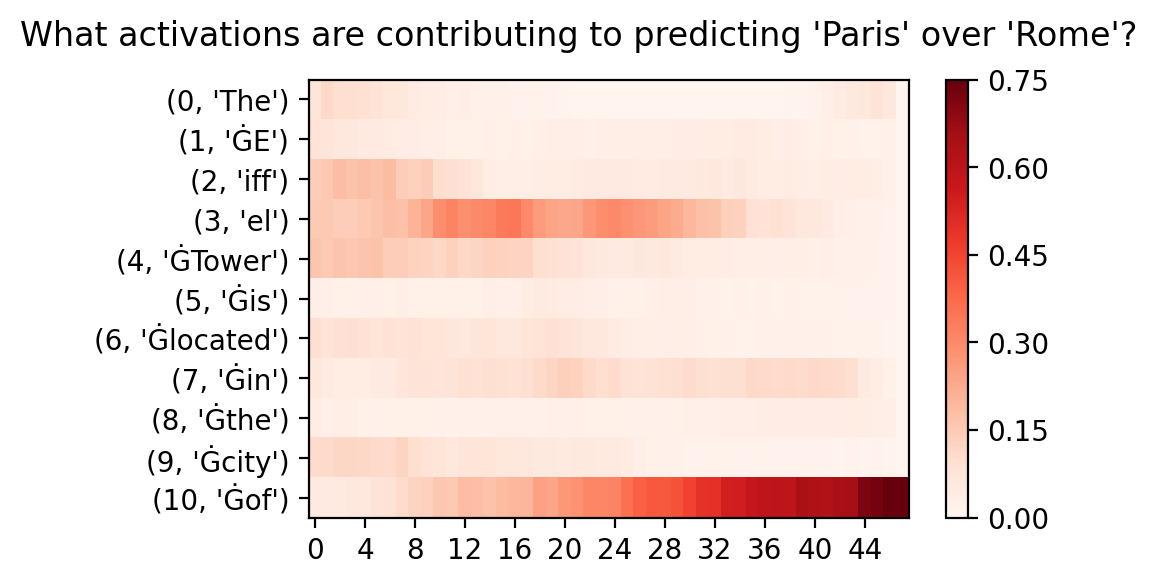

In [8]:
from matplotlib import pyplot as plt

filename = "../img/cat_example_plot.png"

fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
plt.subplots_adjust(bottom=0.15, left=0.275)
h = ax.pcolor(
    attributions_df.values,
    cmap="Reds",
    vmin=0,
    vmax=0.75,
)
ax.invert_yaxis()
ax.set_yticks([0.5 + i for i in range(len(attributions_df.values))])
ax.set_xticks([0.5 + i for i in range(0, attributions_df.values.shape[1], 4)])
ax.set_xticklabels(list(range(0, 48, 4)))
ax.set_yticklabels(attributions_df.index)
cb = plt.colorbar(h, ticks=[0, 0.15, 0.3, 0.45, 0.6, 0.75])
fig.suptitle("What activations are contributing to predicting 'Paris' over 'Rome'?")
plt.savefig(filename)
plt.show()

We can make three observations about this result:

- The last token of the prefix `of` plays an increasingly relevant role in predicting the next token as we go deeper in the model. This is not surprising, as the model needs to rely heavily on local context to preserve fluency.

- The representations formed by the model in its intermediate layers for some subwords composing the subject of the factual association (`iff`, `el`, `Tower`) are influencing the prediction of `Paris` over `Rome`. This can be interpreted as the emebddings formed at these layers encoding some knowledge about the association between `Eiffel Tower` and `Paris`, which is then used to correctly predict the next token.

- The word `in`, expressing the type of relation between subject and target, is also influencing the prediction of `Paris` over `Rome` in the middle to last layers.

In our case study, we conduct an analysis over a full corpus of factual associations, finding that **these patterns are consistent across different examples** and correspond to importance patterns shown by seminal work such as [Meng et al. (2022)](https://rome.baulab.info/) using causal interventions to obtain the same insights.

❗ **Key takeaway**: While feature attributions have been historically used to explain local importance of input features, recent methods like our CAT approach show their potential to **explain where information is encoded in the model**, similarly to probing classifiers, but without the noise introduced by training external probes.

## Conclusion and Let's Build Together!

In this tutorial, we learned how to use modern 🤗-based tools to compute feature attribution for NLP models and evaluate their results. We also learned how to use contrastive attribution to analyze model behavior in more nuanced ways, and how to use contrastive attribution tracing to localize factual knowledge in GPT-2.

We hope this tutorial will be helpful for your research! 😃

**A final note:** the Inseq library is relatively new and born out of a concerted effort of several PhD student and interpretability researchers. Our goal is to build a toolbox that is robust, flexible and easy to use to improve the reproducibility of research in interpretability for NLP. If you want to use Inseq in your research, or even better contribute to its developments, please reach out to us! 🙏 We would be more than happy to help you out and discuss your ideas! 😃